In [66]:
from openfermion.circuits import simulate_trotter
from openfermion.circuits.trotter import LOW_RANK
import openfermion
import cirq
from openfermion.transforms import get_fermion_operator
from openfermion.transforms import jordan_wigner
from openfermion.transforms import bravyi_kitaev
from openfermion import FermionOperator
from openfermion.linalg import sparse_tools

from scipy.linalg import eigh
import scipy
import re 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

In [67]:
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf

dist = 0.74
geometry = [['H',[0,0,0]],
           ['H',[0,0,dist]]]
basis = 'sto-3g'
multiplicity = 1
charge = 0
h2_molecule = MolecularData(geometry, basis, multiplicity, charge)

#If it is the first time executing this program uncomment the following lines
#h2_molecule = run_pyscf(h2_molecule,
#                       run_mp2 = True,
 #                      run_cisd = True,
  #                     run_ccsd = True,
   #                    run_fci = True)
#h2_filename = h2_molecule.filename
#h2_molecule.save()

h2_molecule.load()
h2_hamiltonian = h2_molecule.get_molecular_hamiltonian()
fermion_hamiltonian = get_fermion_operator(h2_hamiltonian)
qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
#qubit_hamiltonian_bk = bravyi_kitaev(fermion_hamiltonian, 4)

In [68]:
def generate_spins(N):
    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        si_n = tensor(op_list)
        
        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
    return si_n, sx_list, sy_list, sz_list

def qubit_hamiltonian_to_qutip(q_hamiltonian, N):
    # first we generate the spin operators in qutip
    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        si_n = tensor(op_list)
        
        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
    
    # read the qubit_hamiltonian from openfermion
    l_h = list(q_hamiltonian)
    s_h_0 = str(l_h[0])
    t1_0 = s_h_0.split()
    numero_0 = t1_0[0].split('+')[0].split('(')[1]
    numero_0 = float(numero_0)
    H = numero_0*si_n
    
    for i in range(1,len(l_h)): 
        s_h = str(l_h[i])
        t1 = s_h.split()
        numero = t1[0].split('+')[0].split('(')[1]
        numero = float(numero)
        lletres = [t1[1][1]]
        numeros = [int(t1[1][2])]
        lletres2 = [j[0] for j in t1[2:]]
        numeros2 = [int(j[1]) for j in t1[2:]]
        let = lletres+lletres2
        num = numeros+numeros2
        H_i = numero*si_n
        for k in range(0,len(let)):
            if let[k] == 'X':
                H_i = H_i*sx_list[num[k]]
            if let[k] == 'Y':
                H_i = H_i*sy_list[num[k]]
            if let[k] == 'Z':
                H_i = H_i*sz_list[num[k]]
            else : 
                H_i = H_i
        H = H + H_i
    
    return H


def generate_Hb(N):
    # N is the length of the chain
    
    si = qeye(2)
    sx = sigmax()
    
    sx_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        si_n = tensor(op_list)
        
        op_list[n] = sx
        sx_list.append(tensor(op_list))

    # construct the hamiltonian
    Hb = 0

    for n in range(N):
        Hb += 1/2*(si_n- sx_list[n])
        
    return Hb

def Hp_coeff(t, args):
    tau = args['tau'] # time scale of the adiabatic evolution
    return t/tau

def Hb_coeff(t,args):
    tau = args['tau'] # time scale of the adiabatic evolution
    return 1-t/tau

def adiabatic_evolution(H, N, args, psi0, tlist):
    # H: Hamiltonian in the format H = [[Hb, Hb_coeff],[Hp, Hp_coeff]]
    # args: arguments of the time dependent function of the hamiltonian, args = {'tau': tau}
    # psi0: initial state to be evolved
    # tlist: list of times for which the evolution is calculated
    c_op_list = []
    options = Options(nsteps=100000, store_states = True)
    result = mesolve(H, psi0, tlist, c_op_list, args = args, options = options) # calculate evolved state at each time
        
    return result.states

def entanglement_entropy(state, partition):
    # Returns the Von Neumann entropy of the partial trace
    # state - state for which we want to calculate the entanglement entropy
    # partition - integer or array of integers from 0 to N-1 that indicate the subsystem
    # with respect to which we calculate the partial trace
    dm = state*state.dag()
    partial_dm = dm.ptrace(partition)
    return entropy_vn(partial_dm, base = 2)

def overlap_with_ground(H, states, tlist, n, plot = True):
    # n = number of lowest states with which the overlap will be calculated
    eigenstates = H.eigenstates(sparse=False, sort='low', eigvals=n, tol=0, maxiter=100000)
    overlaps = []
    for i in range(n):
        overlap = []
        for state in states:
            overlap.append(abs(eigenstates[1][i].overlap(state))**2)
        overlaps.append(overlap)
    if plot == True:
        plt.figure(figsize=(8,6))
        for i in range(n):
            plt.plot(tlist, overlaps[i], label = '%.0f th state'%i)
        plt.xlabel('time')
        plt.ylabel('overlap square')
        plt.legend()
    return overlaps

def H_time(t, Hb, Hp, tau):
    # Time dependent hamiltonian as a function
    return (1-t/tau)* Hb + t/tau * Hp
     
def gap_evolution(H, tlist, plot = True):
    # Hamiltonian evaluated at different times
    energy_0 = [] # ground state energies
    energy_1 = [] # first excited state energies
    gap = [] # diference between ground and first excited energies
    
    for H_i in H:
        energies = H_i.eigenenergies(sparse=False, sort='low', eigvals=2, tol=0, maxiter=100000)
        energy_0.append(energies[0])
        energy_1.append(energies[1])
        gap.append(energies[1]-energies[0])

    if plot == True:
        plt.figure(figsize=(8,6))
        plt.plot(tlist, gap)
        plt.xlabel(r'Time')
        plt.ylabel(r'Gap')
    return energy_0, energy_1

In [70]:
N = 4
#si_N, sx, sy, sz = generate_spins(N)
#H_twobody = -0.0970662681676284*si_N + -0.04530261550379927*sx[0]*sx[1]*sy[2]*sy[3] + 0.04530261550379927*sx[0]*sy[1]*sy[2]*sx[3] + 0.04530261550379927*sy[0]*sx[1]*sx[2]*sy[3]- 0.04530261550379927*sy[0]*sy[1]*sx[2]*sx[3]
#H_onebody = 0.17141282644776887*sz[0]+0.17141282644776887*sz[1]-0.22343153690813575*sz[2]-0.22343153690813575*sz[3]+0.16868898170361213*sz[0]*sz[1]+0.1206252348339042*sz[0]*sz[2]+0.16592785033770346*sz[0]*sz[3]+0.16592785033770346*sz[1]*sz[2]+0.1206252348339042*sz[1]*sz[3]+0.1744128761226159*sz[2]*sz[3]
#Hp = H_twobody + H_onebody
Hp = qubit_hamiltonian_to_qutip(qubit_hamiltonian, N)
Hb = generate_Hb(N)

tau = 35 # time scale of the adiabatic evolution
args = {'tau': tau}

ground = Hb.groundstate(sparse=False, tol=0, maxiter=100000)
psi0 = ground[1] # initial state is the ground state of Hb

tlist = np.linspace(0, tau, tau*2)

# time dependent hamiltonian
H = [[Hb, Hb_coeff], [Hp, Hp_coeff]]
evolved_state = adiabatic_evolution(H, N, args, psi0, tlist)

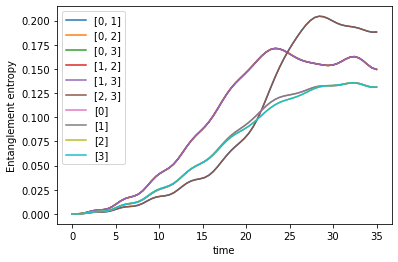

In [71]:
partitions = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0],[1],[2],[3]]
entropies = []
for i in partitions:
    entropy = []
    for state in evolved_state:
        entropy.append(entanglement_entropy(state,i))
    entropies.append(entropy)
    plt.plot(tlist, entropy, label = i)
plt.ylabel('Entanglement entropy')
plt.xlabel('time')
plt.legend()

total_entropy = entropies[0]
for i in range(1,len(entropies)):
    total_entropy = np.add(total_entropy, entropies[i])

In [72]:
ground_Hp = Hp.groundstate(sparse=False, tol=0, maxiter=100000)
psi = ground_Hp[1]

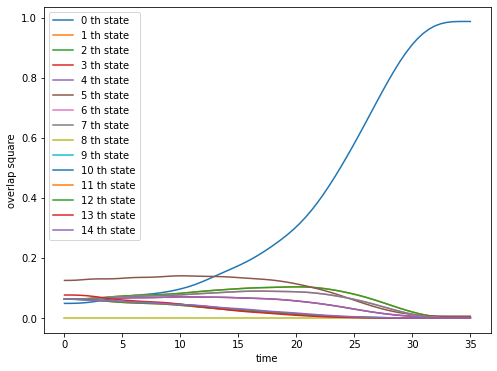

In [73]:
# overlap of the evolved state with the target ground state of Hp
overlap = overlap_with_ground(Hp, evolved_state, tlist, n=15)

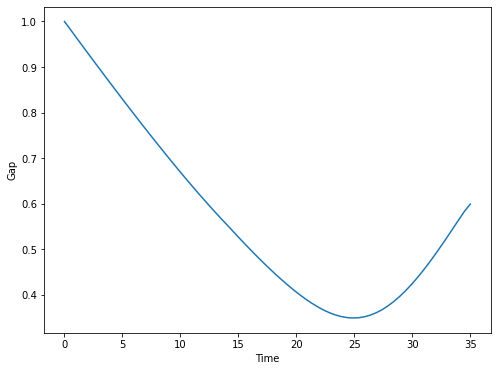

In [74]:
H_t = []
for t in tlist:
    H_t.append(H_time(t, Hb, Hp, tau))
energy0, energy1 = gap_evolution(H_t, tlist, plot = True)

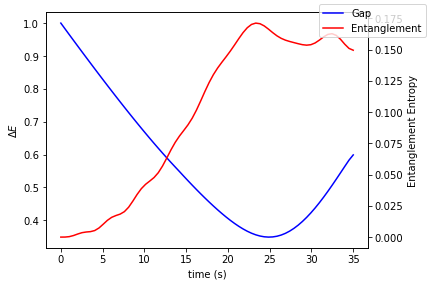

In [75]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel(r'$\Delta E$')
ax1.plot(tlist, np.subtract(energy1,energy0), color='blue', label ='Gap')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Entanglement Entropy')  # we already handled the x-label with ax1
ax2.plot(tlist, entropies[1], color='red', label = 'Entanglement')
#ax2.plot(tlist, entropy2, color='green', label = 'Entanglement')
fig.legend(loc = 1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Different $\tau$

In [76]:
N = 4
Hp = qubit_hamiltonian_to_qutip(qubit_hamiltonian, N)
Hb = generate_Hb(N)

ground = Hb.groundstate(sparse=False, tol=0, maxiter=100000)
psi0 = ground[1] # initial state is the ground state of Hb
time_lists = []
evolved_states = []
# time dependent hamiltonian
H = [[Hb, Hb_coeff], [Hp, Hp_coeff]]

tau_list = [5, 10, 15, 20, 25, 30, 35, 75, 150] # time scale of the adiabatic evolution
for tau in tau_list:
    args = {'tau': tau}
    tlist = np.linspace(0, tau, tau*2)
    time_lists.append(tlist)

    evolved_state = adiabatic_evolution(H, N, args, psi0, tlist)
    evolved_states.append(evolved_state)

In [81]:
entanglements = []
partition = [0,1]
for evolved_state in evolved_states:
    entanglement = []
    for state in evolved_state:
        entanglement.append(entanglement_entropy(state,partition))
    entanglements.append(entanglement)

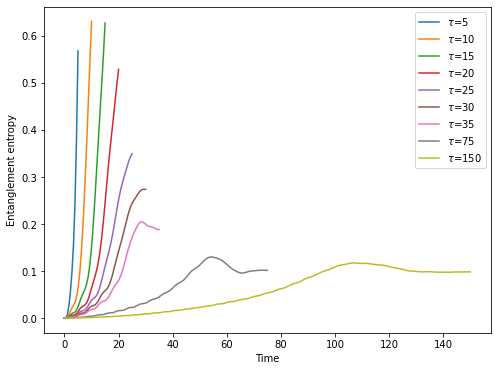

In [82]:
plt.figure(figsize = (8,6))
for i in range(0, len(tau_list)):
    plt.plot(time_lists[i], entanglements[i], label = r'$\tau$=%.0f'%tau_list[i])
plt.ylabel('Entanglement entropy')
plt.xlabel('Time')
plt.legend(loc = 0)

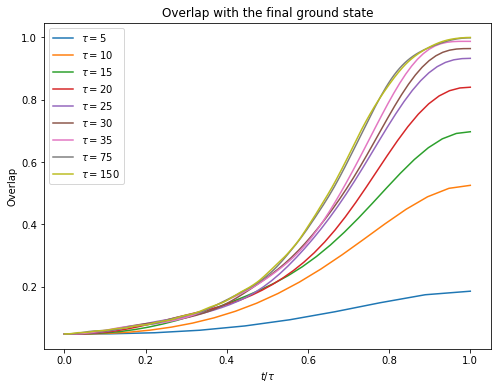

In [83]:
plt.figure(figsize = (8,6))
for i in range(0, len(time_lists)):
    evolved_state = evolved_states[i]
    tlist = time_lists[i]
    overlaps = overlap_with_ground(Hp, evolved_state, tlist, n=1, plot = False)
    plt.plot(tlist/tau_list[i],overlaps[0], label = r'$\tau =$%.0f'%tau_list[i])
plt.xlabel(r'$t/\tau$')
plt.ylabel('Overlap')
plt.title('Overlap with the final ground state')
plt.legend(loc=0)

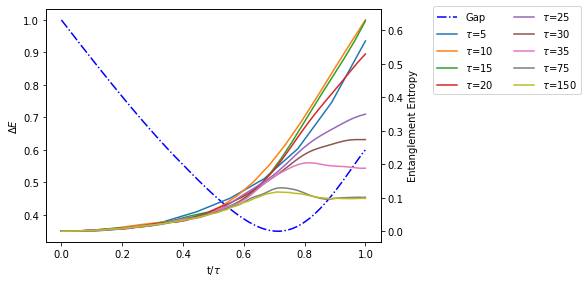

In [86]:
H_t = []
for t in time_lists[-1]:
    H_t.append(H_time(t, Hb, Hp, tau))
energy0, energy1 = gap_evolution(H_t, time_lists[-1],plot = False)

fig, ax1 = plt.subplots()

ax1.set_xlabel(r't/$\tau$')
ax1.set_ylabel(r'$\Delta E$')
ax1.plot(time_lists[-1]/tau_list[-1], np.subtract(energy1,energy0), '-.',color='blue', label ='Gap')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Entanglement Entropy')  # we already handled the x-label with ax1

for i in range(0,len(time_lists)):
    ax2.plot(time_lists[i]/tau_list[i], entanglements[i], label = r'$\tau$=%.0f'%tau_list[i])
#ax2.plot(tlist, entropy2, color='green', label = 'Entanglement')
fig.legend(loc = 3,bbox_to_anchor=(1, 0.65),ncol = 2)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
